In [2]:
# Append 'src' directory to import modules from notebooks directory
#################################
import os,sys
src_dir = os.path.join(os.getcwd(), os.pardir)
sys.path.append(src_dir)
##################################

In [3]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 150)

import time
import os 
import torchvision.models as models
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.model_zoo as model_zoo
import cv2
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from collections import OrderedDict
from PIL import Image,ImageOps
import torch.optim as optim 
from src.models import VGG19
from src import Utils
from src.PatchMatch import PatchMatchOrig



Populating the interactive namespace from numpy and matplotlib


## Defining the model from custom model class
The model class gives some extra functionality

In [4]:
model = VGG19()
model.model

FeatureExtractor (
  (conv_1_1__0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_1__1): ReLU ()
  (conv_1_2__2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_2__3): ReLU ()
  (pool_1__4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_2_1__5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_1__6): ReLU ()
  (conv_2_2__7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_2__8): ReLU ()
  (pool_2__9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_3_1__10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_1__11): ReLU ()
  (conv_3_2__12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_2__13): ReLU ()
  (conv_3_3__14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_3__15): ReLU ()
  (conv_3_4__16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1),

### Input Image Paths

In [5]:
imga_path = './mona2.jpg'
imgbb_path = './ava.jpg'

In [6]:
imga = Utils.load_image(img_path=imga_path,to_array=True,to_variable=True)
imgbb = Utils.load_image(img_path=imgbb_path,to_array=True,to_variable=True)

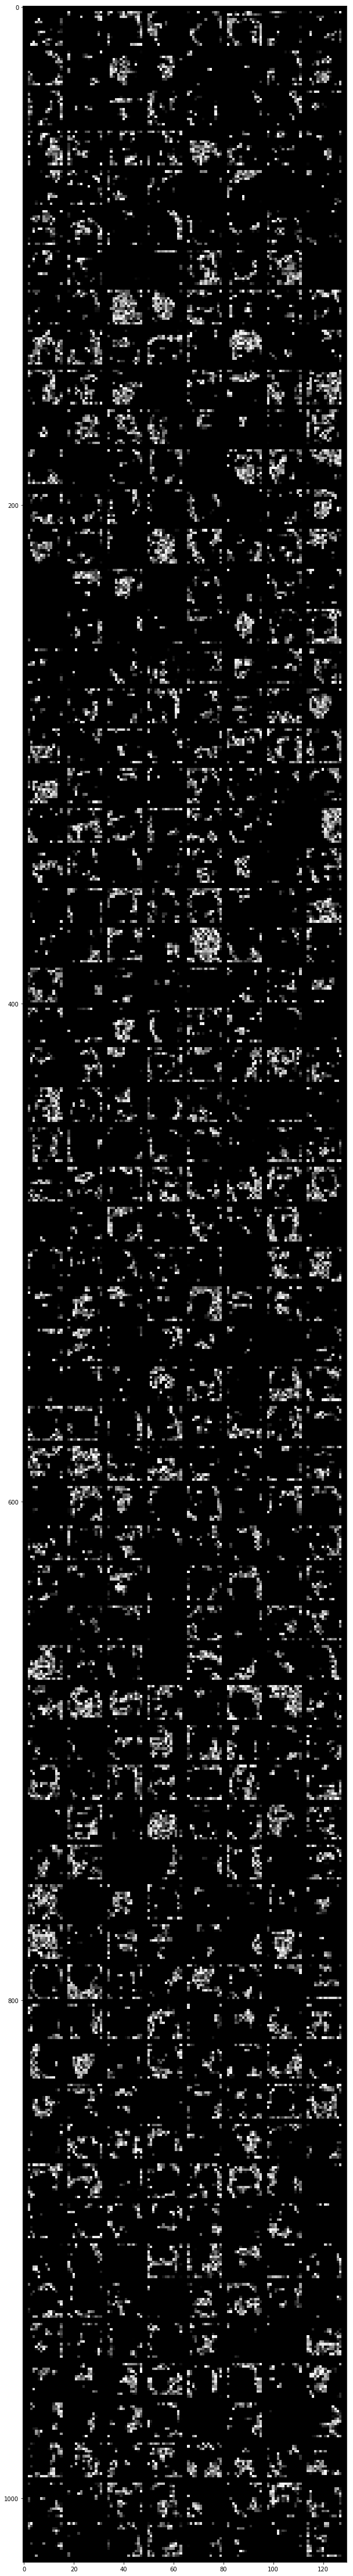

In [7]:
feata = model.get_features_for_layer(img_tensor=imga,layer_num=29).squeeze().numpy()
featbb = model.get_features_for_layer(img_tensor=imgbb,layer_num=29).squeeze().numpy()
plt.imshow(Utils.get_viz_tensor(torch.from_numpy(feata)))

In [8]:
# feat1_norm = feat1/(feat1.max()-feat1.min())
# feat2_norm = feat2/(feat2.max() - feat2.min() )

# feat1_norm = feat1/(feat1.max())
# feat2_norm = feat2/(feat2.max() )

# feata_norm = (feata - np.mean(feata))/(np.std(feata))
# featbb_norm = (featbb - np.mean(featbb))/(np.std(featbb))

feata_min = feata.min(axis=(0),keepdims=True)
feata_max = feata.max(axis=(0),keepdims=True)

featbb_min = featbb.min(axis=(0),keepdims=True)
featbb_max = featbb.max(axis=(0),keepdims=True)

feata_norm = (feata - feata_min)/(feata_max-feata_min)
featbb_norm = (featbb - featbb_min)/(featbb_max-featbb_min)

feata_np_t = feata_norm.transpose(1,2,0) # Channels last
featbb_np_t = featbb_norm.transpose(1,2,0)


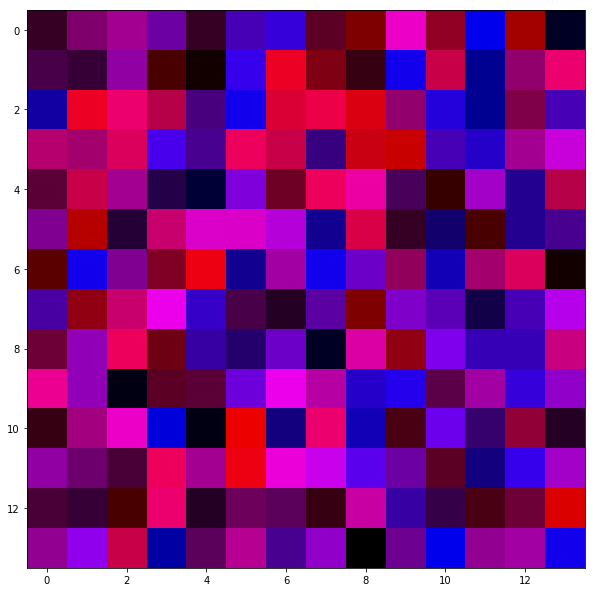

In [9]:
pm5ab = PatchMatchOrig(feata_np_t,feata_np_t,featbb_np_t,featbb_np_t, 5)
plt.imshow(pm5ab.visualize())

done iteration 1
done iteration 2
done iteration 3
done iteration 4
done iteration 5
Done


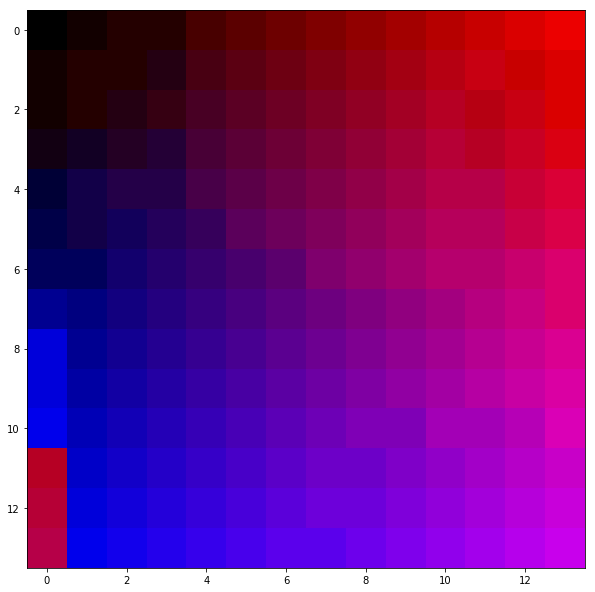

In [10]:
pm5ab.propagate(iters=5,rand_search_radius=6)
plt.imshow(pm5ab.visualize())

In [11]:
imga_raw = Utils.load_image(img_path=imga_path,to_array=False,to_variable=False).numpy().transpose(1,2,0)
imgbb_raw = Utils.load_image(img_path=imgbb_path,to_array=False,to_variable=False).numpy().transpose(1,2,0)
imga_raw.shape

(224, 224, 3)

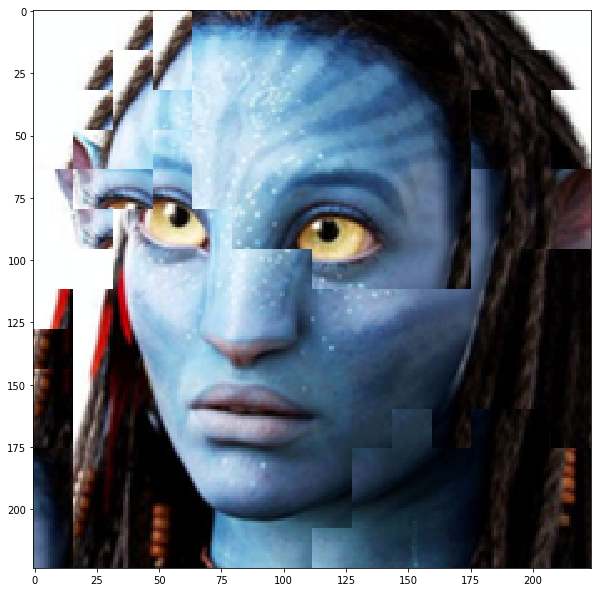

In [12]:
recon = Utils.reconstruct_image(imgbb_raw,pm=pm5ab)
plt.imshow(Utils.deprocess_image(recon))

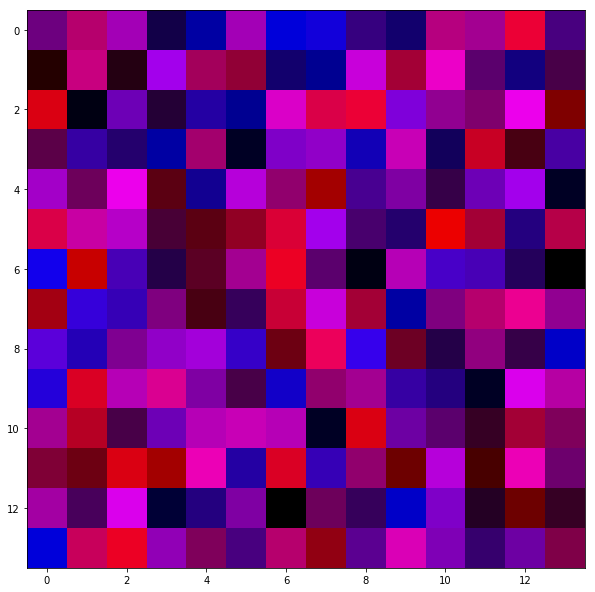

In [13]:
pm5ba = PatchMatchOrig(featbb_np_t,featbb_np_t,feata_np_t,feata_np_t,3)
plt.imshow(pm5ba.visualize())

done iteration 1
done iteration 2
done iteration 3
done iteration 4
done iteration 5
Done


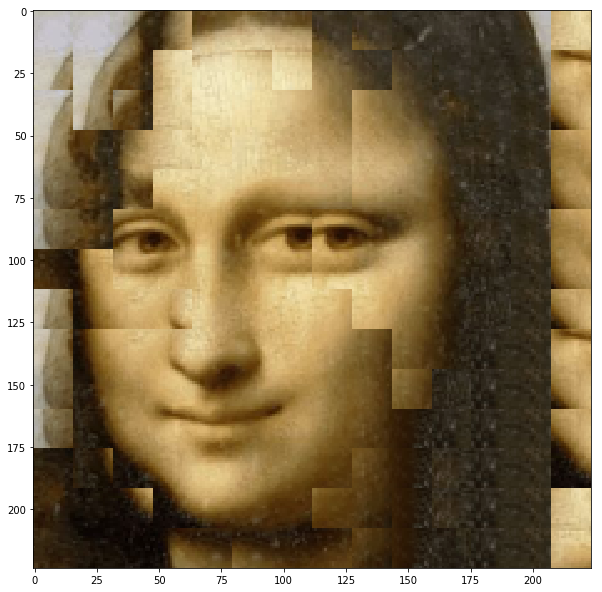

In [14]:
pm5ba.propagate(iters=5,rand_search_radius=5)
plt.imshow(pm5ba.visualize())
recon = Utils.reconstruct_image(imga_raw,pm=pm5ba)
plt.imshow(Utils.deprocess_image(recon))

In [15]:
feat5a = feata.transpose(1,2,0)
feat5bb = featbb.transpose(1,2,0)

warped_feat5bb = Utils.reconstruct_image(feat5bb,pm=pm5ab)
warped_feat5a = Utils.reconstruct_image(feat5a,pm=pm5ba)



In [24]:
def reconstruct_intermediates(pmab,feat_bb,pmba,feat_a):
    feat_a = feat_a.transpose(1,2,0)    
    feat_bb = feat_bb.transpose(1,2,0)
    return Utils.reconstruct_image(feat_bb,pmab) , Utils.reconstruct_image(feat_a,pmba)

def get_deconvoluted_feat(feat,feat_layer_num):
    feat = feat.transpose(2,0,1)
    feat = torch.from_numpy(feat)
    
    if feat_layer_num == 5:
        start_layer,end_layer = 20,28
        noise = np.random.random(size=(1,512,28,28))
    elif feat_layer_num == 4:
        start_layer,end_layer = 11,20
        noise = np.random.random(size=(1,256,56,56))
    elif feat_layer_num == 3:
        start_layer,end_layer = 6,11
        noise = np.random.random(size=(1,128,112,112))
    elif feat_layer_num == 4:
        start_layer,end_layer = 1,6
        noise = np.random.random(size=(1,64,224,224))
    else:
        print("Invalid layer number")
    
    noise = Variable(torch.from_numpy(noise).float(),requires_grad=True)
    noise = noise.cuda()
    noise = nn.Parameter(noise.data.clone())
    optimizer = optim.LBFGS([noise])
    model.model = model.model.cuda()
    
    feat = Variable(feat).cuda()
    
    loss = nn.MSELoss()
    def closure():
        optimizer.zero_grad()
        output = model.forward_subnet(input_tensor=noise,start_layer=start_layer,end_layer=end_layer)
        loss_valu = loss(output,feat)
        loss_valu.backward()
        return loss_valu

    loss_hist = []
    for i in range(200):
        loss_hist.append(optimizer.step(closure).cpu().data.numpy())
    pylab.rcParams['figure.figsize'] = (10, 10)
    plt.plot(loss_hist)
    return noise.cpu().data.numpy()
    

    
    


In [ ]:
optimized = get_deconvoluted_feat(warped_feat5bb,5)

In [21]:
warped_feat5bb.summary()

AttributeError: 'numpy.ndarray' object has no attribute 'summary'

In [22]:
from scipy import stats

In [23]:
stats.describe(warped_feat5bb)

DescribeResult(nobs=14, minmax=(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32), array([[  1.32698536,   1.02662921,   2.55430532, ...,   5.56716871,
          4.85663223,   5.95598793],
       [  1.32698536,   1.02662921,   0.        , ...,   2.43086338,
         10.89976215,   7.05617619],
       [  0.83344144,   3.89540505,   0.        , ...,   4.0502553 ,
          2.71957016,   0.9718892 ],
       ..., 
       [  0.27929798,   1.62228048,   6.41483736, ...,   0.        ,
          2.03184581,   0.        ],
       [  6.49309587,   2.58913875,   6.41483736, ...,   0.46836293,
          0.60041523,   0.        ],
       [  0.        ,   2.96416187,   2.93878508, ...,   0.        ,
          0.        ,   2.20164824]], dtype=float32)), mean=ar